# Clean and feature extraction v5

## Clean text, extract stylometric, lexical and complexity features and create a new csv

## We are using `spacy`: The NLP *Ruby on Rails* 

[spacy](http://www.spacy.io/) is a library of natural language processing, robust, fast, easy to install and to use. It can be used with other NLP and Deep Learning Libraries.

With its pre-trained models in spanish language, we can operate the typical NLP jobs: Sentences segmentation, tokenization, POS tag, etc...

We are going to use the `es_core_news_lg` pre-trained model to make pos tagging:

### Also extracting headline features 

## V5 with syllabizer, avg_syllables, and readability spanish tests

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/corpus_spanish.csv')

In [3]:
df.head()

Id Category          Topic         Source  \
0  641     True  Entertainment          Caras   
1    6     True      Education        Heraldo   
2  141     True        Science       HUFFPOST   
3  394     True       Politics  El financiero   
4  139     True          Sport           FIFA   

                                            Headline  \
0  Sofía Castro y Alejandro Peña Pretelini: una i...   
1   Un paso más cerca de hacer los exámenes 'online'   
2  Esto es lo que los científicos realmente piens...   
3  Inicia impresión de boletas para elección pres...   
4                         A *NUMBER* día del Mundial   

                                                Text  \
0  Sofía Castro y Alejandro Peña Pretelini: una i...   
1  Un paso más cerca de hacer los exámenes 'onlin...   
2  Esto es lo que los científicos realmente piens...   
3  Inicia impresión de boletas para elección pres...   
4  A *NUMBER* día del Mundial\nFIFA.com sigue la ...   

                                                Link  
0  https://www.caras.com.mx/sofia-castro-alejandr...  
1  https://www.heraldo.es/noticias/suplementos/he...  
2  https://www.huffingtonpost.com/entry/scientist...  
3  http://www.elfinanciero.com.mx/elecciones-2018...  
4  https://es.fifa.com/worldcup/news/a-1-dia-del-...

In [4]:
df.shape

(971, 7)

In [5]:
df.dtypes

Id           int64
Category    object
Topic       object
Source      object
Headline    object
Text        object
Link        object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        971 non-null    int64 
 1   Category  971 non-null    object
 2   Topic     971 non-null    object
 3   Source    971 non-null    object
 4   Headline  971 non-null    object
 5   Text      971 non-null    object
 6   Link      971 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.2+ KB


In [21]:
df.sample(5)

Id Category          Topic          Source  \
525  555     True       Politics     CNN español   
746  633     True  Entertainment         Milenio   
60   563     Fake       Politics       Censura 0   
10   278     Fake  Entertainment  El Ruinaversal   
152  235     True        Economy   El financiero   

                                              Headline  \
525  Trump enviará tropas de la Guardia Nacional a ...   
746  Yuawi López prepara canción para el Mundial Ru...   
60   Angélica Rivera: "AMLO no llegará a ser presid...   
10   Disney compra los derechos para explotar la im...   
152  AMLO aceleraría el consumo y el crecimiento ec...   

                                                  Text  \
525  Trump enviará tropas de la Guardia Nacional a ...   
746  Yuawi López prepara canción para el Mundial Ru...   
60   Angélica Rivera: "AMLO no llegará a ser presid...   
10   Disney compra los derechos para explotar la im...   
152  AMLO aceleraría el consumo y el crecimiento ec...   

                                                  Link  
525  https://cnnespanol.cnn.com/2018/04/04/la-casa-...  
746  http://www.milenio.com/virales/yuawi-lopez-pre...  
60   http://censura0.com/2018/04/03/angelica-rivera...  
10   http://www.elruinaversal.com/2017/06/20/disney...  
152  http://www.elfinanciero.com.mx/economia/amlo-a...

In [42]:
import re
text = df['Text'].iloc[1]
text = re.sub(r"http\S+", "", text)
text = re.sub(r"http", "", text)
text = re.sub(r"@\S+", "", text)
text = re.sub("\n", " ", text)
text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
text = text.replace(r"*NUMBER*", "número")
text = text.replace(r"*PHONE*", "número")
text = text.replace(r"*EMAIL*", "email")
text = text.replace(r"*URL*", "url")
text

'Un paso más cerca de hacer los exámenes \'online\' Cerca de número universitarios de seis universidades europeas participan este cuatrimestre en la última fase de pruebas de un programa informático que permitirá certificar la identidad y autoría de los estudiantes cuando realizan actividades \'online\' como exámenes, trabajos u otras pruebas. El proyecto se encuentra en la tercera y última fase de pruebas piloto, en la que se pone a prueba la versión "final" del \'software\', que incluye herramientas de reconocimiento facial, de voz y otras que capturan patrones de escritura, detectan plagio y analizan el lenguaje y el estilo de redacción, según sus impulsores. En dicha fase hay una primera prueba en la que están participando número estudiantes y en la que la Universitat Oberta de Catalunya (UOC) participa con número estudiantes, número profesores y número docentes; y una segunda prueba en la que participarán entre número y número estudiantes. "El balance de las dos pruebas [anteriore

In [43]:
alph = list(filter(str.isalpha, text))
ratio_upper_case_letters = round(sum(map(str.isupper, alph)) / len(alph) * 100, 2)
ratio_upper_case_letters

7.23

## Apply it to the full corpus with iterrows()

In [46]:
# Tried several syllabizers for spanish and this is the chosen solution. Believe me, i spent a whole day.
# I had to replace all symbols, punctuations and it includes accentuation from other languages like ä, à, etc...
# It's a bit inconsistent with words from others languages, acronyms and abbreviations. However it performs really well

def get_nsyllables(text):
    from syltippy import syllabize

    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    text = re.sub(r'\d+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'[^ \nA-Za-z0-9ÁÉÍÓÚÑáéíóúñ/]+', '', text)
    
    n_syllables = len(syllabize(text)[0])
    
    return n_syllables

In [99]:
%%time

import itertools
import pandas as pd
import nltk
import spacy
import re
from nltk import FreqDist
from sklearn.preprocessing import LabelEncoder
from lexical_diversity import lex_div as ld
pd.options.display.max_columns = None

nlp = spacy.load('es_core_news_lg')

df = pd.read_csv('../data/corpus_spanish.csv')

labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Category'])

# empty lists and df
df_features = pd.DataFrame()
list_text = []
list_sentences = []
list_words = []
list_words_sent = []
list_word_size = []
list_avg_syllables_word = []
list_unique_words = []
list_ttr = []
list_mltd = []
list_entity_ratio = []
list_i_fernandez_huerta = []
list_i_szigriszt_pazos = []
list_ratio_uc_letters = []
list_nquotes = []
list_quotes_ratio = []
list_propn_ratio = [] 
list_noun_ratio = []
list_adp_ratio = []
list_det_ratio = []
list_punct_ratio = []
list_pron_ratio = []
list_verb_ratio = []
list_adv_ratio = []
list_sym_ratio = []

list_headline = []
list_words_h = []
list_word_size_h = []
list_avg_syllables_word_h = []
list_ttr_h = []
list_mltd_h = []
list_unique_words_h = []

# df iteration
for n, row in df.iterrows():
    
    ## headline ##
    headline = df['Headline'].iloc[n]
    headline = re.sub(r"http\S+", "", headline)
    headline = re.sub(r"http", "", headline)
    headline = re.sub(r"@\S+", "", headline)
    headline = re.sub("\n", " ", headline)
    headline = re.sub(r"(?<!\n)\n(?!\n)", " ", headline)
    headline = headline.replace(r"*NUMBER*", "número")
    headline = headline.replace(r"*PHONE*", "número")
    headline = headline.replace(r"*EMAIL*", "email")
    headline = headline.replace(r"*URL*", "url")
    headline_new = headline.lower()
    doc_h = nlp(headline_new)
    
    list_tokens_h = []
    list_tags_h = []
    n_sents_h = 0

    for sentence_h in doc_h.sents:
        n_sents_h += 1
        for token in sentence_h:
            list_tokens_h.append(token.text)

    fdist_h = FreqDist(list_tokens_h)
    n_syllables_h = get_nsyllables(headline)
    n_words_h = len(list_tokens_h)
    
    # headline complexity features
    avg_word_size_h = round(sum(len(word) for word in list_tokens_h) / n_words_h, 2)
    avg_syllables_word_h = round(n_syllables_h / n_words_h, 2)
    unique_words_h = round((len(fdist_h.hapaxes()) / n_words_h) * 100, 2)
    ttr_h = round(ld.ttr(list_tokens_h) * 100, 2)
    mltd_h = round(ld.mtld(list_tokens_h), 2)
    
    ## text content##   
    text = df['Text'].iloc[n]  
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
#     text = re.sub(r"@\S+", "", text)
    text = re.sub("\n", " ", text)
#     text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")
    
    # to later calculate upper case letters ratio
    alph = list(filter(str.isalpha, text))
    text_new = text.lower()
    doc = nlp(text_new)

    list_tokens = []
    list_pos = []
    list_tag = []
    list_entities = []
    n_sents = 0
    
    for entity in doc.ents:
        list_entities.append(entity.label_)

    for sentence in doc.sents:
        n_sents += 1
        for token in sentence:
            list_tokens.append(token.text)
            list_pos.append(token.pos_)
            list_tag.append(token.tag_)
    
    # Calculate entities, pos, tag, freq, syllables, wordsand quotes
    n_entities = len(list_entities)
    n_pos = nltk.Counter(list_pos)
    n_tag = nltk.Counter(list_tag)
    fdist = FreqDist(list_tokens)
    n_syllables = get_nsyllables(text)
    n_words = len(list_tokens)
    n_quotes = n_tag['PUNCT__PunctType=Quot']

    # complexity features
    avg_word_sentence = round(n_words / n_sents, 2)
    avg_word_size = round(sum(len(word) for word in list_tokens) / n_words, 2)
    avg_syllables_word = round(n_syllables / n_words, 2)
    unique_words = round((len(fdist.hapaxes()) / n_words) * 100, 2)
    ttr = round(ld.ttr(list_tokens) * 100, 2)
    mltd = round(ld.mtld(list_tokens), 2)

    # readability spanish test
    i_fernandez_huerta = round(206.84 - (60 * avg_syllables_word) - (1.02 * avg_word_sentence), 2)
    i_szigriszt_pazos = round(206.835 - ((62.3 * n_syllables) / n_words) - (n_words / n_sents), 2)

    # stylometric features
    ratio_uc_letters = round(sum(map(str.isupper, alph)) / len(alph) * 100, 2)
    entity_ratio = round((n_entities / n_words) * 100, 2)
    quotes_ratio = round((n_quotes / n_words) * 100, 2)
    propn_ratio = round((n_pos['PROPN'] / n_words) * 100 , 2)
    noun_ratio = round((n_pos['NOUN'] / n_words) * 100, 2) 
    adp_ratio = round((n_pos['ADP'] / n_words) * 100, 2)
    det_ratio = round((n_pos['DET'] / n_words) * 100, 2)
    punct_ratio = round((n_pos['PUNCT'] / n_words) * 100, 2)
    pron_ratio = round((n_pos['PRON'] / n_words) * 100, 2)
    verb_ratio = round((n_pos['VERB'] / n_words) * 100, 2)
    adv_ratio = round((n_pos['ADV'] / n_words) * 100, 2)
    sym_ratio = round((n_tag['SYM'] / n_words) * 100, 2)
    
    # appending on lists
    # headline
    list_headline.append(headline_new)
    list_words_h.append(n_words_h)
    list_word_size_h.append(avg_word_size_h)
    list_avg_syllables_word_h.append(avg_syllables_word_h)
    list_unique_words_h.append(unique_words_h)
    list_ttr_h.append(ttr_h)
    list_mltd_h.append(mltd_h)
    
    # text
    list_text.append(text_new)
    list_sentences.append(n_sents)
    list_words.append(n_words)
    list_words_sent.append(avg_word_sentence)
    list_word_size.append(avg_word_size)
    list_avg_syllables_word.append(avg_syllables_word)
    list_unique_words.append(unique_words)
    list_ttr.append(ttr)
    list_mltd.append(mltd)
    list_i_fernandez_huerta.append(i_fernandez_huerta)
    list_i_szigriszt_pazos.append(i_szigriszt_pazos)
    list_entity_ratio.append(entity_ratio)
    list_ratio_uc_letters.append(ratio_uc_letters)
    list_nquotes.append(n_quotes)
    list_quotes_ratio.append(quotes_ratio)
    list_propn_ratio.append(propn_ratio)
    list_noun_ratio.append(noun_ratio)
    list_adp_ratio.append(adp_ratio)
    list_det_ratio.append(det_ratio)
    list_punct_ratio.append(punct_ratio)
    list_pron_ratio.append(pron_ratio)
    list_verb_ratio.append(verb_ratio)
    list_adv_ratio.append(adv_ratio)
    list_sym_ratio.append(sym_ratio)
    
# dataframe
df_features['text'] = list_text
df_features['headline'] = list_headline

# headline
df_features['words_h'] = list_words_h
df_features['word_size_h'] = list_word_size_h
df_features['avg_syllables_word_h'] = list_avg_syllables_word_h
df_features['unique_words_h'] = list_unique_words_h
df_features['ttr_h'] = list_ttr_h
df_features['mltd_h'] = list_mltd_h

# text
df_features['sents'] = list_sentences
df_features['words'] = list_words
df_features['avg_words_sent'] = list_words_sent
df_features['avg_word_size'] = list_word_size
df_features['avg_syllables_word'] = list_avg_syllables_word
df_features['unique_words'] = list_unique_words
df_features['ttr'] = list_ttr
df_features['mltd'] = list_mltd
df_features['i_fernandez_huerta'] = list_i_fernandez_huerta
df_features['i_szigriszt_pazos'] = list_i_szigriszt_pazos
df_features['ratio_uc_letters'] = list_ratio_uc_letters
df_features['entity_ratio'] = list_entity_ratio
df_features['n_quotes'] = list_nquotes
df_features['quotes_ratio'] = list_quotes_ratio
df_features['propn_ratio'] = list_propn_ratio
df_features['noun_ratio'] = list_noun_ratio
df_features['adp_ratio'] = list_adp_ratio
df_features['det_ratio'] = list_det_ratio
df_features['punct_ratio'] = list_punct_ratio
df_features['pron_ratio'] = list_pron_ratio
df_features['verb_ratio'] = list_verb_ratio
df_features['adv_ratio'] = list_adv_ratio
df_features['sym_ratio'] = list_sym_ratio

df_features['label'] = df['Label']

df_features.to_csv('../data/spanish_corpus_features_v5.csv', encoding = 'utf-8', index = False)

CPU times: user 1min 13s, sys: 1.8 s, total: 1min 15s
Wall time: 1min 15s


In [101]:
df_features.head()

text  \
0  sofía castro y alejandro peña pretelini: una i...   
1  un paso más cerca de hacer los exámenes 'onlin...   
2  esto es lo que los científicos realmente piens...   
3  inicia impresión de boletas para elección pres...   
4  a número día del mundial fifa.com sigue la cue...   

                                            headline  words_h  word_size_h  \
0  sofía castro y alejandro peña pretelini: una i...       12         5.58   
1   un paso más cerca de hacer los exámenes 'online'       11         3.64   
2  esto es lo que los científicos realmente piens...       12         4.83   
3  inicia impresión de boletas para elección pres...        7         6.86   
4                           a número día del mundial        5         4.00   

   avg_syllables_word_h  unique_words_h   ttr_h  mltd_h  sents  words  \
0                  2.50          100.00  100.00    0.00      6    244   
1                  1.55           81.82   90.91   33.88      9    462   
2                  1.67           83.33   91.67   40.32     29    956   
3                  2.71          100.00  100.00    0.00     10    347   
4                  1.80          100.00  100.00    0.00      4    117   

   avg_words_sent  avg_word_size  avg_syllables_word  unique_words    ttr  \
0           40.67           4.30                1.78         36.07  50.82   
1           51.33           4.42                1.79         34.42  46.10   
2           32.97           4.91                1.95         26.67  39.33   
3           34.70           4.97                2.02         24.21  39.19   
4           29.25           4.85                2.00         53.85  64.96   

    mltd  i_fernandez_huerta  i_szigriszt_pazos  ratio_uc_letters  \
0  55.73               58.56              55.10              4.39   
1  44.90               47.08              44.25              7.23   
2  78.16               56.21              52.59              1.60   
3  54.51               50.25              46.28              2.66   
4  55.90               57.01              52.99              4.50   

   entity_ratio  n_quotes  quotes_ratio  propn_ratio  noun_ratio  adp_ratio  \
0          7.38         0          0.00        15.57       15.98      14.34   
1          9.52         4          0.87        16.67       17.10      12.99   
2          2.93        39          4.08         4.81       18.62      14.33   
3          2.88         4          1.15         4.32       25.94      19.31   
4          8.55         0          0.00        11.11       19.66      19.66   

   det_ratio  punct_ratio  pron_ratio  verb_ratio  adv_ratio  sym_ratio  label  
0      11.89         9.02        5.74        6.56       3.28       0.00      1  
1      11.69        18.83        1.30        3.46       1.73       1.30      1  
2      13.08        11.72        2.62       10.56       4.81       0.21      1  
3      16.14         9.80        2.88        7.78       0.29       0.00      1  
4      15.38         6.84        3.42        4.27       1.71       0.00      1

## Data visualization of features

In [70]:
df_features.columns

Index(['text', 'headline', 'words_h', 'word_size_h', 'avg_syllables_word_h',
       'unique_words_h', 'ttr_h', 'mltd_h', 'sents', 'words', 'avg_words_sent',
       'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd',
       'i_fernandez_huerta', 'i_szigriszt_pazos', 'ratio_uc_letters',
       'entity_ratio', 'n_quotes', 'quotes_ratio', 'propn_ratio', 'noun_ratio',
       'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio',
       'adv_ratio', 'sym_ratio', 'label'],
      dtype='object')

<AxesSubplot:xlabel='features', ylabel='value'>

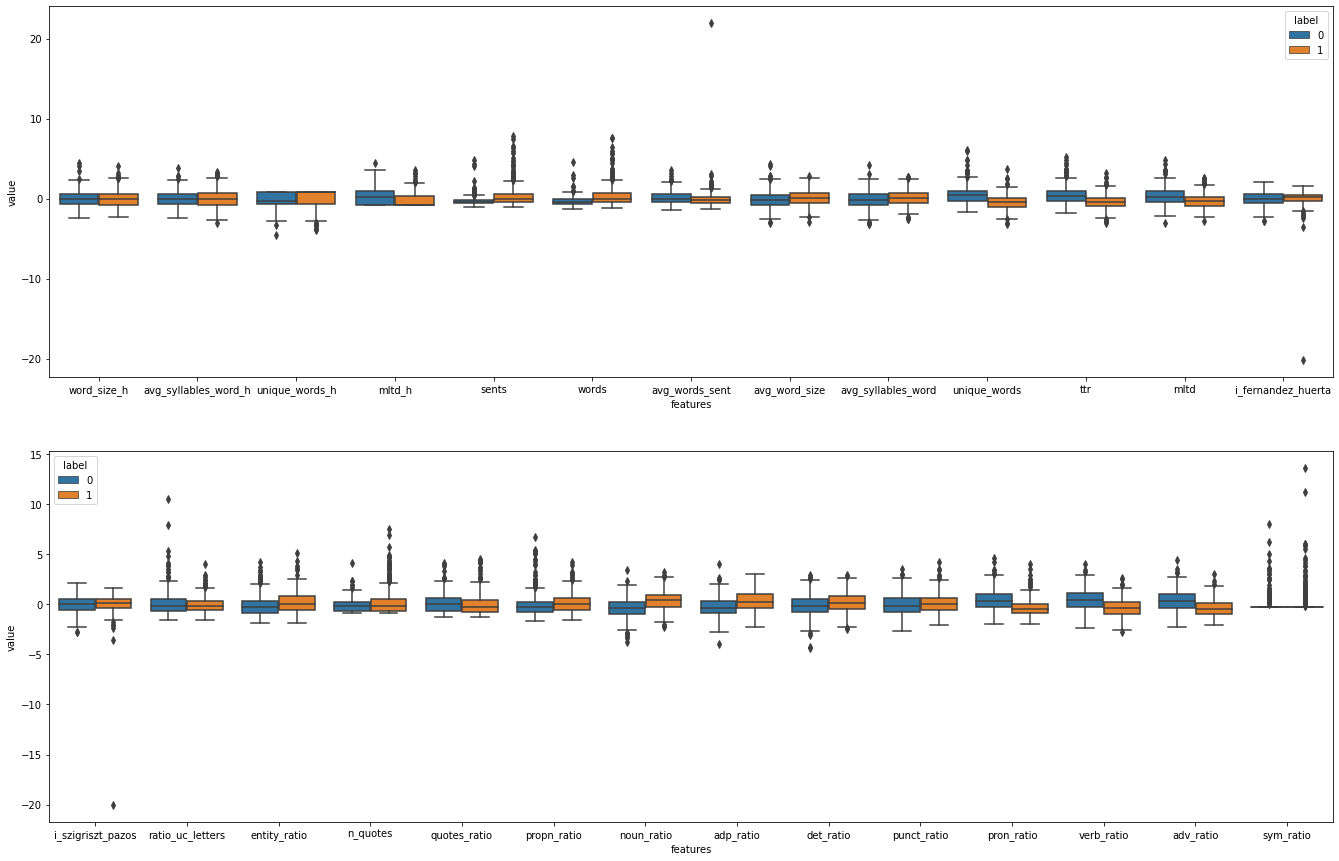

In [103]:
import seaborn as sns
from matplotlib import pyplot as plt

# All features don't fit well in 1 graphic so we divide it in 2 graphics

features1 = ['word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'mltd_h', 'sents', 'words',
             'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 'i_fernandez_huerta']

features2 = ['i_szigriszt_pazos', 'ratio_uc_letters', 'entity_ratio', 'n_quotes', 'quotes_ratio', 'propn_ratio', 'noun_ratio',
             'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 'sym_ratio']

y = df_features['label']
x1 = df_features[features1]
x2 = df_features[features2]

# standarization
x1_st = (x1 - x1.mean()) / (x1.std())
x2_st = (x2 - x2.mean()) / (x2.std())

data1 = pd.concat([y, x1_st.iloc[:,]], axis = 1)
data1 = pd.melt(data1, id_vars = "label", var_name = "features", value_name = 'value')

data2 = pd.concat([y, x2_st.iloc[:,]], axis = 1)
data2 = pd.melt(data2, id_vars = "label", var_name = "features", value_name = 'value')

f, axs = plt.subplots(2, figsize = (23, 15))

sns.boxplot(x = "features", y = "value", hue = "label", data = data1, ax = axs[0])
sns.boxplot(x = "features", y = "value", hue = "label", data = data2, ax = axs[1])